In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs
import time


def cf(u, T,r,q,sigma):
    ''' Funkcja charakterystyczna w modelu Kou '''
    b =r - q  - 0.5 * sigma ** 2
    value = np.exp(T*(1j * u * b - 0.5 * u ** 2 * sigma ** 2))
    return value


def CallPutOptionPriceCOSMthd(cf,S0,r,q,T,K,sigma,N,L,parity):
        
    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)

    i = np.complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # Truncation domain

    c1=T*(r-q-0.5*sigma**2)
    c2=sigma**2 * T
    a=x0+c1-L*np.sqrt(c2)
    b=x0+c1+L*np.sqrt(c2)
    # Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u, T,r,q,sigma) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * T) * K * np.real(mat.dot(temp))
    if parity==True:
        return  value + np.exp(-q*T)*S0 - K*np.exp(-r*T)
    else:
        return value

# Determine coefficients for put prices 

def CallPutCoefficients(a,b,k):
    
    c = a
    d = 0.0
    coef = Chi_Psi(a,b,c,d,k)
    Chi_k = coef["chi"]
    Psi_k = coef["psi"]
    if a<b and b<0.0:
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k) 
    elif a>0 and a<b:
        H_k = np.zeros([len(k),1])
    else:
        H_k = 2.0 / (b - a) * (- Chi_k + Psi_k)
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value
    

# def value(S0,K, sigma, T):
#         ''' Returns option value.
#         '''
        
#         d1 = ((np.log(S0 / K) +
#                (r-q + 0.5 * sigma ** 2) * T) /
#               (sigma * np.sqrt(T)))
#         d2 = ((np.log(S0 / K) +
#                (r-q - 0.5 * sigma ** 2) * T) /
#               (sigma * np.sqrt(T)))
#         value = (S0*np.exp(-q*T) * scs.norm.cdf(d1, 0.0, 1.0) -
#                  K * np.exp(-r * T) * scs.norm.cdf(d2, 0.0, 1.0))
#         return value

def BS_Call_Option_Price(S0,K,sigma,T,r,q):
    #Black-Scholes Call option price
    d1    = (np.log(S0 / K) + (r -q + 0.5 * np.power(sigma,2.0)) 
    * T) / float(sigma * np.sqrt(T))
    d2    = d1 - sigma * np.sqrt(T)
    value = scs.norm.cdf(d1) *np.exp(-q*T)* S0 - scs.norm.cdf(d2) * K * np.exp(-r * T)
    return value

def mainCalculation():
    i = np.complex(0.0,1.0)

#     N=8
    L = 10
    K = 125
    S0 = 100
    r = 0.05
    q = 0.0
    T =0.1
    sigma = 0.2
    
    val_Exact = BS_Call_Option_Price(S0,K,sigma,T,r,q)
    
    for n in [8,16,32,64,128,1024]:
        val_COS = CallPutOptionPriceCOSMthd(cf,S0,r,q,T,(K,),sigma,n,L,True)[0][0]
        error = np.abs(val_COS-val_Exact)
        print("Błąd dla ceny wykonania", K ,"oraz N=",n ,"wynosi {0:.2e}".format(error))
        print("Faktyczna cena wynosi", K ,"wynosi {:.10f}".format(val_Exact))
#         print("Cena z metody COS wynosi", K ,"wynosi {:.10f}".format(val_COS))       
mainCalculation()

Błąd dla ceny wykonania 125 oraz N= 8 wynosi 3.36e-02
Faktyczna cena wynosi 125 wynosi 0.0005041474
Błąd dla ceny wykonania 125 oraz N= 16 wynosi 7.36e-03
Faktyczna cena wynosi 125 wynosi 0.0005041474
Błąd dla ceny wykonania 125 oraz N= 32 wynosi 5.13e-09
Faktyczna cena wynosi 125 wynosi 0.0005041474
Błąd dla ceny wykonania 125 oraz N= 64 wynosi 1.61e-14
Faktyczna cena wynosi 125 wynosi 0.0005041474
Błąd dla ceny wykonania 125 oraz N= 128 wynosi 1.61e-14
Faktyczna cena wynosi 125 wynosi 0.0005041474
Błąd dla ceny wykonania 125 oraz N= 1024 wynosi 1.61e-14
Faktyczna cena wynosi 125 wynosi 0.0005041474


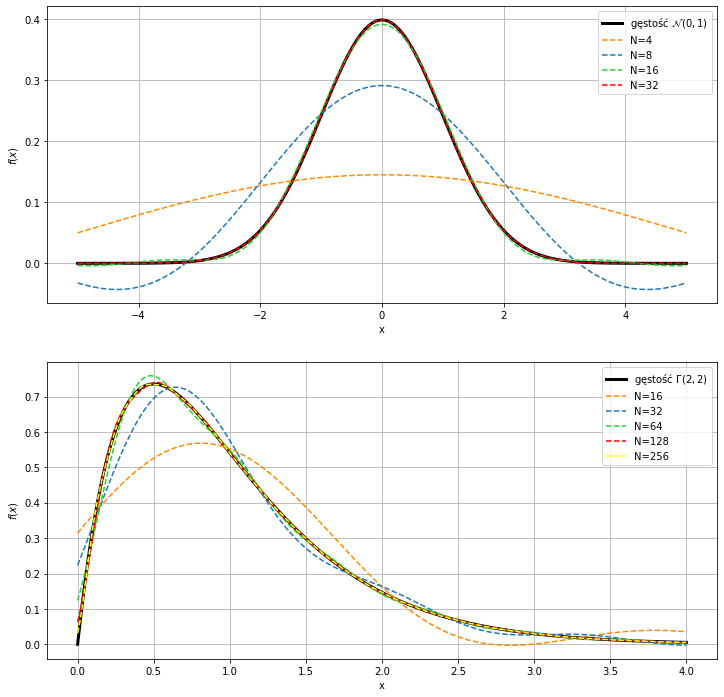

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import matplotlib
from cycler import cycler

def COSDensity(cf,x,N,a,b):
    i = np.complex(0.0,1.0) #assigning i=sqrt(-1)
    k = np.linspace(0,N-1,N)
    u = np.zeros([1,N])
    u = k * np.pi / (b-a)
        
    # F_k coefficients

    F_k    = 2.0 / (b - a) * np.real(cf(u) * np.exp(-i * u * a));
    F_k[0] = F_k[0] * 0.5; # adjustment for the first term
    
    # Final calculation

    f_X = np.matmul(F_k , np.cos(np.outer(u, x - a )))
        
    # We output only the first row

    return f_X
    
def mainCalculation():
    i = np.complex(0.0, 1.0) #assigning i=sqrt(-1)
    
    # Setting for the COS method 

    a_ = -10.0
    b_ = 10.0
    
    # Define the range for the expansion points

    N = [2**x for x in range(2,6)]
    
    # Setting for normal distribution

    mu = 0.0
    sigma = 1.0 
        
    # Define characteristic function for the normal distribution

    cF = lambda u : np.exp(i * mu * u - 0.5 * np.power(sigma,2.0) * np.power(u,2.0));
    
    # Define the domain for density    

    
    plt.figure(figsize=(12, 12))
    plt.rc('axes', prop_cycle=(cycler('color', ['darkorange','tab:blue','limegreen','red','yellow'])))
    
    # Rozkład normalny
    plt.subplot(211)
    x = np.linspace(-5.0,5,10000)
    f_XExact = st.norm.pdf(x,mu,sigma)
    
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("$f(x)$")
    plt.plot(x,f_XExact,color='k',linewidth=3,label='gęstość $\mathcal{N}(0,1)$')
    for n in N:
        f_X = COSDensity(cF,x,n,a_,b_)
        plt.plot(x,f_X,label='N=%s' %n,linestyle='--')    
    plt.legend()
   
    # Rozkład gamma
    plt.subplot(212)
    N = [2**x for x in range(4,9)]  
    colors=['tab:blue','red','darkorange','springgreen','tab:purple']
    a = 2
    b = 2
    cF = lambda u : (1-i*u/b)**(-a)
    x = np.linspace(0,4,10000)
    f_XExact = st.gamma.pdf(x, a=2, scale=0.5) 
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("$f(x)$")
    plt.plot(x,f_XExact,color='k',linewidth=3,fillstyle='none',label='gęstość $\Gamma(2,2)$')
    for n in N:
        f_X = COSDensity(cF,x,n,a_,b_)
        plt.plot(x,f_X,label='N=%s' %n,linestyle='--')    
    plt.legend()
 
    plt.savefig('COS_density', dpi=400)
    
    

mainCalculation()